In [1]:
import sys 
sys.path.append('../..')
sys.path.append('/opt/anaconda3/lib/python3.7/site-packages')
from cox.utils import Parameters
from cox.store import Store
from cox.readers import CollectionReader
import matplotlib.pyplot as plt
import seaborn as sns
import torch as ch
from torch import Tensor
from torch import sigmoid as sig
import torch.nn as nn
from torch.optim import SGD, lr_scheduler
from torch.distributions import Gumbel, Uniform
from torch.distributions.multivariate_normal import MultivariateNormal
from torch.distributions.transforms import SigmoidTransform
from torch.distributions.transformed_distribution import TransformedDistribution
from torch.utils.data import TensorDataset, DataLoader
import torch.nn.functional as F
import time
from tqdm.autonotebook import tqdm as tqdm
from abc import ABC
import IPython
import os
import dill

# Constants

In [2]:

TRUNCATED_STORE_PATH = '/Users/patroklos/MultinomialLogisticRegressionTruncated/'
STANDARD_STORE_PATH = '/Users/patroklos/MultinomialLogisticRegressionStandard/'

TRUNCATED_EVAL_STORE_PATH = '/Users/patroklos/MultinomialLogisticRegressionTruncatedTest/'
STANDARD_EVAL_STORE_PATH = '/Users/patroklos/MultinomialLogisticRegressionStandardTest/'

GUMBEL_CE_STORE_PATH = '/Users/patroklos/MultinomialLogisticRegressionGumbelCE'

LOGS_SCHEMA = {
    'epoch':int,
    'val_prec1':float,
    'val_loss':float,
    'train_prec1':float,
    'train_loss':float,
    'time':float
}

EVAL_LOGS_SCHEMA = {
    'test_prec1':float,
    'test_loss':float,
    'time':float
}

GROUND_TRUTH_SCHEMA = { 
    'cos_sim': float, 
    'l2': float,
    'epoch': int,
}

# scheduler constants
CYCLIC='cyclic'
COSINE='cosine'
LINEAR='linear'

LOGS_TABLE = 'logs'
EVAL_LOGS_TABLE = 'eval'
GROUND_TRUTH_TABLE ='ground_truth'

CKPT_NAME = 'checkpoint.pt'
BEST_APPEND = '.best'
CKPT_NAME_LATEST = CKPT_NAME + '.latest'
CKPT_NAME_BEST = CKPT_NAME + BEST_APPEND

# Training and Evaluation Procedure Functions

In [10]:
def make_optimizer_and_schedule(args, model, params):
    param_list = model.parameters() if params is None else params

    optimizer = SGD(param_list, args.lr, momentum=args.momentum, weight_decay=args.weight_decay)

    # Make schedule
    schedule = None
    if args.custom_lr_multiplier == CYCLIC:
        eps = args.epochs
        lr_func = lambda t: np.interp([t], [0, eps*4//15, eps], [0, 1, 0])[0]
        schedule = lr_scheduler.LambdaLR(optimizer, lr_func)
    elif args.custom_lr_multiplier == COSINE:
        eps = args.epochs
        schedule = lr_scheduler.CosineAnnealingLR(optimizer, eps)
    elif args.custom_lr_multiplier:
        cs = args.custom_lr_multiplier
        periods = eval(cs) if type(cs) is str else cs
        if args.lr_interpolation == LINEAR:
            lr_func = lambda t: np.interp([t], *zip(*periods))[0]
        else:
            def lr_func(ep):
                for (milestone, lr) in reversed(periods):
                    if ep >= milestone: return lr
                return 1.0
        schedule = lr_scheduler.LambdaLR(optimizer, lr_func)
    elif args.step_lr:
        schedule = lr_scheduler.StepLR(optimizer, step_size=args.step_lr, gamma=args.step_lr_gamma)
        
    return optimizer, schedule


def eval_model(args, model, loader, store):
    """
    Evaluate a model for standard (and optionally adversarial) accuracy.
    Args:
        args (object) : A list of arguments---should be a python object
            implementing ``getattr()`` and ``setattr()``.
        model (AttackerModel) : model to evaluate
        loader (iterable) : a dataloader serving `(input, label)` batches from
            the validation set
        store (cox.Store) : store for saving results in (via tensorboardX)
    """
    start_time = time.time()

    if store is not None:
        store.add_table(EVAL_LOGS_TABLE, EVAL_LOGS_SCHEMA)
    writer = store.tensorboard if store else None

    # put model on device
    model.to(args.device)

    assert not hasattr(model, "module"), "model is already in DataParallel."
    if next(model.parameters()).is_cuda and False:
        model = ch.nn.DataParallel(model)

    test_prec1, test_loss, score = model_loop(args, 'val', loader,
                                        model, None, 0, writer, args.device)

    log_info = {
        'test_prec1': test_prec1,
        'test_loss': test_loss,
        'time': time.time() - start_time
    }

    # Log info into the logs table
    if store:
        store[EVAL_LOGS_TABLE].append_row(log_info)
        store.close()

    return log_info


def train_model(args, model, loaders, *, ground_truth=None, device="cpu", dp_device_ids=None,
                store=None, update_params=None, disable_no_grad=False):
    # clear jupyter/ipython output before each training run
    if store is not None:
        store.add_table(LOGS_TABLE, LOGS_SCHEMA)
        # ground-truth comparison table
        if ground_truth is not None: 
            store.add_table(GROUND_TRUTH_TABLE, GROUND_TRUTH_SCHEMA)
    writer = store.tensorboard if store else None

    # data loaders
    train_loader, val_loader = loaders
    optimizer, schedule = make_optimizer_and_schedule(args, model, update_params)

    # put the model into parallel mode
    assert not has_attr(model, "module"), "model is already in DataParallel."

    model.to(device)

    best_prec1, start_epoch = (0, 0)

    # keep track of the start time
    start_time = time.time()
    for epoch in range(start_epoch, args.epochs):
        train_prec1, train_loss, score = model_loop(args, 'train', train_loader, model, optimizer, epoch+1, writer, device=device)

        # check score tolerance
        if args.score and ch.all(ch.where(ch.abs(score) < args.tol, ch.ones(1), ch.zeros(1)).bool()):
            break

        last_epoch = (epoch == (args.epochs - 1))

        # if neural network passed through framework, use log performance
        if args.should_save_ckpt:
            save_its = args.save_ckpt_iters
            should_save_ckpt = (epoch % save_its == 0) and (save_its > 0)
            should_log = (epoch % args.log_iters == 0)

            if should_log or last_epoch or should_save_ckpt:
                # log + get best
                ctx = ch.enable_grad() if disable_no_grad else ch.no_grad()
                with ctx:
                    val_prec1, val_loss, score = model_loop(args, 'val', val_loader, model,
                            None, epoch + 1, writer, device=device)

                # remember best prec@1 and save checkpoint
                is_best = val_prec1 > best_prec1
                best_prec1 = max(val_prec1, best_prec1)

                # log every checkpoint
                log_info = {
                    'epoch': epoch + 1,
                    'val_prec1': val_prec1,
                    'val_loss': val_loss,
                    'train_prec1': train_prec1,
                    'train_loss': train_loss,
                    'time': time.time() - start_time
                }

                # Log info into the logs table
                if store: store[LOGS_TABLE].append_row(log_info)
        
        # update lr
        if schedule: schedule.step()

        tqdm._instances.clear()
        
        if ground_truth is not None: 
            # ground_truth and current model parameters
            gt_params = ch.cat([ground_truth.weight.flatten(), ground_truth.bias]).unsqueeze(1)
            trunc_params = ch.cat([model.weight.flatten(), model.bias]).unsqueeze(1)
            # cosine similarity and l2 distance
            cos_sim = float(ch.nn.functional.cosine_similarity(gt_params, trunc_params, dim=0))
            l2_dist = float(ch.nn.MSELoss()(gt_params, trunc_params))
            
            ground_truth_info = { 
                'epoch': epoch + 1, 
                'cos_sim': cos_sim, 
                'l2': l2_dist,
            }
            
            store[GROUND_TRUTH_TABLE].append_row(ground_truth_info)
            
    # close store at end of training
    if store is not None:
        store.close()
    return model
            
            
def model_loop(args, loop_type, loader, model, optimizer, epoch, writer, device):
    # check loop type 
    if not loop_type in ['train', 'val']: 
        err_msg = "loop type must be in {0} must be 'train' or 'val".format(loop_type)
        raise ValueError(err_msg)
    is_train = (loop_type == 'train')
    
    loop_msg = 'Train' if is_train else 'Val'

    # algorithm metrics
    losses = AverageMeter()
    top1 = AverageMeter()
    top5 = AverageMeter()
    score = AverageMeter()
    
    # check for custom criterion
    has_custom_criterion = has_attr(args, 'custom_criterion')
    criterion = args.custom_criterion if has_custom_criterion else ch.nn.CrossEntropyLoss()

    iterator = tqdm(enumerate(loader), total=len(loader), leave=False)
    for i, batch in iterator:
        inp, target, output = None, None, None
        loss = 0.0

        inp, target = batch
        inp, target = inp.to(device), target.to(device)
        output = model(inp)
        # attacker model returns both output anf final input
        if isinstance(output, tuple):
            output, final_inp = output
        # lambda parameter used for regression with unknown noise variance
        try:
            loss = criterion(output, target, model.lambda_)
        except Exception as e:
            loss = criterion(output, target)

        # regularizer option 
        reg_term = 0.0
        if has_attr(args, "regularizer") and isinstance(model, ch.nn.Module):
            reg_term = args.regularizer(model, inp, target)
        loss = loss + reg_term
        
        # perform backprop and take optimizer step
        if is_train:
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

        if len(loss.size()) > 0: loss = loss.mean()

        model_logits = output[0] if isinstance(output, tuple) else output

        # measure accuracy and record loss
        top1_acc = float('nan')
        top5_acc = float('nan')
        try:
            losses.update(loss.item(), inp.size(0))
            # calculate score
            if args.bias:
                score.update(ch.cat([model.weight.grad.T, model.bias.grad.unsqueeze(0)]).flatten(), inp.size(0))
            else:
                score.update(ch.cat([model.weight.grad.T]).flatten(), inp.size(0))

            if model_logits is not None:
                # accuracy
                maxk = min(5, model_logits.shape[-1])
                if has_attr(args, "custom_accuracy"):
                    prec1, prec5 = args.custom_accuracy(model_logits, target)
                else:
                    prec1, prec5 = accuracy(model_logits, target, topk=(1, maxk))
                    prec1, prec5 = prec1[0], prec5[0]

                top1.update(prec1, inp.size(0))
                top5.update(prec5, inp.size(0))
                top1_acc = top1.avg
                top5_acc = top5.avg

                # ITERATOR
                desc = ('Epoch:{0} | Score: {score} \n | Loss {loss.avg:.4f} | '
                        '{1}1 {top1_acc:.3f} | {1}5 {top5_acc:.3f} | '
                        'Reg term: {reg} ||'.format(epoch, loop_msg, score=[round(x, 4) for x in score.avg.tolist()],
                                                    loss=losses, top1_acc=top1_acc, top5_acc=top5_acc, reg=reg_term))
        except Exception as e:
            warnings.warn('Failed to calculate the accuracy.')
            # ITERATOR
            desc = ('Epoch:{0} |  Score: {score} \n | Loss {loss.avg:.4f} ||'.format(
                epoch, loop_msg, score=[round(x, 4) for x in score.avg.tolist()], loss=losses))
        
        iterator.set_description(desc)
    
        # USER-DEFINED HOOK
        if has_attr(args, 'iteration_hook'):
            args.iteration_hook(model, i, loop_type, inp, target)

    if writer is not None:
        descs = ['loss', 'top1', 'top5']
        vals = [losses, top1, top5]
        for d, v in zip(descs, vals):
            writer.add_scalar('_'.join([loop_type, d]), v.avg,
                              epoch)

    # ACCURACY, LOSS, AND SCORE
    return top1.avg, losses.avg, score.avg

# Helper Functions

In [4]:
# membership oracles
class oracle(ABC):
    """
    Oracle for data sets.
    """
    def __call__(self, x):
        """
        Membership oracle.
        Args: 
            x: samples to check membership
        """
        pass

class DNN_Lower(oracle): 
    """
    Lower bound truncation on the DNN logits.
    """
    def __init__(self, lower): 
        self.lower = lower
        
    def __call__(self, x): 
        return (x > self.lower).float()
    
class DNN_Logit_Ball(oracle): 
    """
    Truncation ball placed on DNN logits.
    INTUITION: logits that are neither very large nor very small insinuate
    that the classification is not 
    """
    def __init__(self, lower, upper): 
        self.lower = lower 
        self.upper = upper
        
    def __call__(self, x): 
        return ((x < self.lower) | (x > self.upper)).float()
        

class Identity(oracle): 
    """
    Identity membership oracle for DNNs. All logits are accepted within the truncation set.
    """
    def __call__(self, x): 
        return ch.ones(x.size())
    
def gen_data(): 
    """
    Generate dataset for truncated multinomial logistic 
    regression model. Returns ground_truth and train, validation, and test loaders.
    """
    # distributions
    gumbel = Gumbel(0, 1)
    U = Uniform(args.lower, args.upper) # distribution to generate ground-truth parameters
    U_ = Uniform(-5, 5) # distribution to generate samples
    
    # no grad required for dataset
    with ch.no_grad():
        # generate synthetic data until survival probability of more than 40%
        alpha = None
        while alpha is None or alpha < args.ALPHA_THRESH:
            # generate ground-truth from uniform distribution
            ground_truth = nn.Linear(in_features=args.IN_FEATURES, out_features=args.K, bias=args.bias)
            ground_truth.weight = nn.Parameter(U.sample(ch.Size([args.K, args.IN_FEATURES])))
            if ground_truth.bias is not None: 
                ground_truth.bias = nn.Parameter(U.sample(ch.Size([args.K,])))
            # independent variable 
            X = U_.sample(ch.Size([args.samples, args.IN_FEATURES]))
            # determine base model logits 
            z = ground_truth(X)
            # add noise to the logits
            noised = z + gumbel.sample(z.size())
            # apply softmax to unnormalized likelihoods
            y = ch.argmax(noised, dim=1)

            # TRUNCATE
            trunc = args.phi(z)
            indices = ch.all(trunc.bool(), dim=1).float().nonzero(as_tuple=False).flatten()
            x_trunc, y_trunc = X[indices], y[indices]
            alpha = x_trunc.size(0) / X.size(0)

            # all synthetic data 
            ds = TensorDataset(x_trunc, y_trunc)
            # split ds into training and validation data sets - 80% training, 20% validation
            train_length = int(len(ds)*.8)
            val_length = len(ds) - train_length
            train_ds, val_ds = ch.utils.data.random_split(ds, [train_length, val_length])
            # train and validation loaders
            train_loader = DataLoader(train_ds, num_workers=args.num_workers, batch_size=args.batch_size)
            val_loader = DataLoader(val_ds, num_workers=args.num_workers, batch_size=args.batch_size)

            # test dataset
            x_test = X[~indices]
            y_test = y[~indices]
            test_ds = TensorDataset(x_test, y_test)
            test_loader = DataLoader(test_ds, num_workers=args.num_workers, batch_size=args.batch_size)
            
    return ground_truth, (train_loader, val_loader), test_loader

def plot():
    # TRUNCATED CE LOSS DATA
    trunc_reader = CollectionReader(TRUNCATED_STORE_PATH)
    trunc_logs = trunc_reader.df(LOGS_TABLE)
    trunc_comp = trunc_reader.df(GROUND_TRUTH_TABLE)
    trunc_reader.close() # close reader

    # STANDARD CE LOSS DATA
    standard_reader = CollectionReader(STANDARD_STORE_PATH)
    standard_logs = standard_reader.df(LOGS_TABLE)
    standard_comp = standard_reader.df(GROUND_TRUTH_TABLE)
    standard_reader.close() # close reader

    sns.lineplot(data=trunc_logs, x='epoch', y='train_loss', label='Train Loss')
    sns.lineplot(data=standard_logs, x='epoch', y='train_loss', label='Naive Train Loss')
    sns.lineplot(data=trunc_logs, x='epoch', y='val_loss', color='red', label='Trunc Val Loss')
    ax = sns.lineplot(data=standard_logs, x='epoch', y='val_loss', color='red', label='Naive Val Loss')
    ax.set(xlabel='Epoch', ylabel='CE Loss')
    plt.show()

    sns.lineplot(data=trunc_logs, x='epoch', y='train_prec1', label='Trunc Train Acc')
    sns.lineplot(data=standard_logs, x='epoch', y='train_prec1', label='Naive Train Acc')
    sns.lineplot(data=trunc_logs, x='epoch', y='val_prec1', label='Trunc Val Acc')
    ax = sns.lineplot(data=standard_logs, x='epoch', y='val_prec1', label='Naive Val Acc')
    ax.set(xlabel='Epoch', ylabel='Accuracy')
    plt.show()
    
    sns.lineplot(data=standard_comp, x='epoch', y='cos_sim', label='Naive Cosine Similarity')
    ax = sns.lineplot(data=trunc_comp, x='epoch', y='cos_sim', label='Truncated Cosine Similarity')
    ax.set(xlabel='Epoch', ylabel='Cosine Similarity')
    plt.show()
    
    sns.lineplot(data=standard_comp, x='epoch', y='l2', label='Naive L2')
    ax = sns.lineplot(data=trunc_comp, x='epoch', y='l2', label='Truncated L2')
    ax.set(xlabel='Epoch', ylabel='L2 Distance')
    plt.show()
    
    try: 
        # STANDARD TEST SET RESULTS 
        standard_test_reader = CollectionReader(STANDARD_EVAL_STORE_PATH)
        standard_test_results = standard_test_reader.df(EVAL_LOGS_TABLE)
        standard_test_reader.close() # close reader
        
        # TRUNCATED TEST SET RESULTS 
        trunc_test_reader = CollectionReader(TRUNCATED_EVAL_STORE_PATH)
        trunc_test_results = trunc_test_reader.df(EVAL_LOGS_TABLE)
        trunc_test_reader.close() # close reader

        print("Standard Test Accuracy: {}".format(standard_test_results['test_prec1']))
        print("Truncated Test Accuracy: {}".format(trunc_test_results['test_prec1']))
    except: 
        print("No Test Results to Report")
        
        
class AverageMeter(object):
    """Computes and stores the average and current value"""
    def __init__(self):
        self.reset()

    def reset(self):
        self.val = 0
        self.avg = 0
        self.sum = 0
        self.count = 0

    def update(self, val, n=1):
        self.val = val
        self.sum += val * n
        self.count += n
        self.avg = self.sum / self.count
        
def has_attr(obj, k):
    """Checks both that obj.k exists and is not equal to None"""
    try:
        return (getattr(obj, k) is not None)
    except KeyError as e:
        return False
    except AttributeError as e:
        return False
    
def accuracy(output, target, topk=(1,), exact=False):
    """
        Computes the top-k accuracy for the specified values of k

        Args:
            output (ch.Tensor) : model output (N, classes) or (N, attributes) 
                for sigmoid/multitask binary classification
            target (ch.Tensor) : correct labels (N,) [multiclass] or (N,
                attributes) [multitask binary]
            topk (tuple) : for each item "k" in this tuple, this method
                will return the top-k accuracy
            exact (bool) : whether to return aggregate statistics (if
                False) or per-example correctness (if True)

        Returns:
            A list of top-k accuracies.
    """
    with ch.no_grad():
        # Binary Classification
        if len(target.shape) > 1:
            assert output.shape == target.shape, \
                "Detected binary classification but output shape != target shape"
            return [ch.round(ch.sigmoid(output)).eq(ch.round(target)).float().mean()], [-1.0] 

        maxk = max(topk)
        batch_size = target.size(0)

        _, pred = output.topk(maxk, 1, True, True)
        pred = pred.t()
        correct = pred.eq(target.view(1, -1).expand_as(pred))

        res = []
        res_exact = []
        for k in topk:
            correct_k = correct[:k].reshape(-1).float()
            ck_sum = correct_k.sum(0, keepdim=True)
            res.append(ck_sum.mul_(100.0 / batch_size))
            res_exact.append(correct_k)

        if not exact:
            return res
        else:
            return res_exact
        
def ckpt_at_epoch(num):
    return '%s_%s' % (num, CKPT_NAME)

# Gradients

In [5]:
class TruncatedBCE(ch.autograd.Function):
    @staticmethod
    def forward(ctx, pred, targ):
        ctx.save_for_backward(pred, targ)
        loss = ch.nn.BCEWithLogitsLoss()
        return loss(pred, targ)

    @staticmethod
    def backward(ctx, grad_output):
        pred, targ = ctx.saved_tensors

        # logistic distribution
        base_distribution = Uniform(0, 1)
        transforms_ = [SigmoidTransform().inv]
        logistic = TransformedDistribution(base_distribution, transforms_)

        stacked = pred[None, ...].repeat(args.num_samples, 1, 1)
        # add noise
        noised = stacked + logistic.sample(stacked.size())
        # filter
        filtered = ch.stack([args.phi(batch) for batch in noised]).float()
        out = (noised * filtered).sum(dim=0) / (filtered.sum(dim=0) + 1e-5)
        grad = ch.where(ch.abs(out) > 1e-5, sig(out), targ) - targ
        return grad / pred.size(0), -grad / pred.size(0)

class GumbelCE(ch.autograd.Function):
    @staticmethod
    def forward(ctx, pred, targ):
        ctx.save_for_backward(pred, targ)
        ce_loss = ch.nn.CrossEntropyLoss()
        return ce_loss(pred, targ)

    @staticmethod
    def backward(ctx, grad_output):
        pred, targ = ctx.saved_tensors
        # gumbel distribution
        gumbel = Gumbel(0, 1)
        # make num_samples copies of pred logits
        stacked = pred[None, ...].repeat(args.num_samples, 1, 1)        
        # add gumbel noise to logits
        rand_noise = gumbel.sample(stacked.size())
        noised = stacked + rand_noise 
        noised_labs = noised.argmax(-1)
        # remove the logits from the trials, where the kth logit is not the largest value
        good_mask = noised_labs.eq(targ)[..., None]
        inner_exp = 1 - ch.exp(-rand_noise)
        avg = (inner_exp * good_mask).sum(0) / (good_mask.sum(0) + 1e-5) / pred.size(0)
        return -avg , None
    
class TruncatedGumbelCE(ch.autograd.Function):
    @staticmethod
    def forward(ctx, pred, targ):
        ctx.save_for_backward(pred, targ)
        ce_loss = ch.nn.CrossEntropyLoss()
        return ce_loss(pred, targ)

    @staticmethod
    def backward(ctx, grad_output):
        pred, targ = ctx.saved_tensors
        # initialize gumbel distribution
        gumbel = Gumbel(0, 1)
        # make num_samples copies of pred logits
        stacked = pred[None, ...].repeat(args.num_samples, 1, 1)   
        # add gumbel noise to logits
        rand_noise = gumbel.sample(stacked.size())
        noised = stacked + rand_noise 
        # truncate - if one of the noisy logits does not fall within the truncation set, remove it
        filtered = ch.all(args.phi(noised).bool(), dim=2).float().unsqueeze(2)
        noised_labs = noised.argmax(-1)
        # mask takes care of invalid logits and truncation set
        mask = noised_labs.eq(targ)[..., None] * filtered
        inner_exp = 1 - ch.exp(-rand_noise)

        avg = (((inner_exp * mask).sum(0) / (mask.sum(0) + 1e-5)) - ((inner_exp * filtered).sum(0) / (filtered.sum(0) + 1e-5))) 
        return -avg / pred.size(0), None, None

# gradients
trunc_bce = TruncatedBCE.apply
gumbel_ce = GumbelCE.apply
trunc_ce = TruncatedGumbelCE.apply

# Default Experiment HyperParameters

In [6]:
# procedure hyperparameters
args = Parameters({ 
    'epochs': 25,
    'num_workers': 0, 
    'batch_size': 100,
    'bias': True,
    'num_samples': 1000,
    'clamp': True, 
    'radius': 5.0, 
    'lr': 1e-1,
    'shuffle': False, 
    'samples': 10000,  # number of samples to generate for ground truth
    'in_features': 2, # number of in-features to multi-log-reg
    'k': 2, # number of classes
    'lower': -1, # lower bound for generating ground truth weights
    'upper': 1,  # upper bound for generating ground truth weights
    'trials': 5,
    'log_iters': 1,    
    'should_save_ckpt': True,
    'save_ckpt_iters': -1,
    'validation_split': .8,
    'momentum': 0.0,
    'weight_decay': 0.0,
    'custom_lr_multiplier': COSINE, 
    'shuffle': True,
    'device': 'cpu',
    'alpha_thresh': .2,
})

if ch.cuda.is_available(): 
    args.__setattr__('device', 'cuda')
else: 
    args.__setattr__('device', 'cpu')
args

{
  "epochs": 25,
  "num_workers": 0,
  "batch_size": 100,
  "bias": true,
  "num_samples": 1000,
  "clamp": true,
  "radius": 5.0,
  "lr": 0.1,
  "shuffle": true,
  "samples": 10000,
  "in_features": 2,
  "k": 2,
  "lower": -1,
  "upper": 1,
  "trials": 5,
  "log_iters": 1,
  "should_save_ckpt": true,
  "save_ckpt_iters": -1,
  "validation_split": 0.8,
  "momentum": 0.0,
  "weight_decay": 0.0,
  "custom_lr_multiplier": "cosine",
  "device": "cpu",
  "alpha_thresh": 0.2
}

# Truncated Multinomial Logistic Regression Experiments

In [7]:
# phi = DNN_Lower(ch.full(ch.Size([args.K,]), -2, dtype=ch.float32))
# phi = DNN_Lower(Tensor([-2, -3, -2, -3, -4, -5, -6, -7, -6, -5]))
phi = Identity()
# phi = DNN_Logit_Ball(ch.full(ch.Size([args.K,]), -2, dtype=ch.float32), ch.full(ch.Size([args.K,]), 2, dtype=ch.float32))
args.__setattr__('phi', phi)

# Experiment

In [8]:
# perform number of trials experiments
for i in range(args.trials):
    # generate data for exp
    ground_truth, loaders, test_loader = gen_data()

    # new classifier models at the beginning of each trial
    trunc_multi_log_reg = nn.Linear(in_features=args.IN_FEATURES, out_features=args.K, bias=args.bias)

    # truncated store
    out_store = Store(TRUNCATED_STORE_PATH)
    args.__setattr__('custom_criterion', trunc_ce)  # truncated ce loss
    train_model(args, trunc_multi_log_reg, loaders, ground_truth=ground_truth, store=out_store, device=args.device)
    # clear output
    IPython.display.clear_output(wait=False)

    # new classifier models at the beginning of each trial
    standard_multi_log_reg = nn.Linear(in_features=args.IN_FEATURES, out_features=args.K, bias=args.bias)

    # naive ce loss
    out_store = Store(STANDARD_STORE_PATH)
    args.__setattr__('custom_criterion', None) # default ce loss
    train_model(args, standard_multi_log_reg, loaders, ground_truth=ground_truth, store=out_store, device=args.device)
    # clear output   
    IPython.display.clear_output(wait=False)
    
    # Gumbel CE store path 
    out_store = Store(GUMBEL_CE_STORE_PATH)
    args.__setattr__('custom_criterion', gumbel_ce)
    gumbel_ce_multi_log_reg = nn.Linear(in_features=args.IN_FEATURES, out_features=args.K, bias=args.bias)
    train_model(args, gumbel_ce_multi_log_reg, loaders, ground_truth=ground_truth, store=out_store, device=args.device)
    # clear output
    IPython.display.clear_output(wait=False)

    # standard multinomial logistic regression eval - if there is a test set
    if len(test_loader.dataset) > 0:
        # truncated multinomial logistic regression eval
        out_store = Store(TRUNCATED_EVAL_STORE_PATH)
        eval_model(args, trunc_multi_log_reg, test_loader, out_store)
        # clear output
        IPython.display.clear_output(wait=False)
        
        # standard multinomial logistic regression eval
        out_store = Store(STANDARD_EVAL_STORE_PATH)
        eval_model(args, standard_multi_log_reg, test_loader, out_store)
        # clear output
        IPython.display.clear_output(wait=False)

100%|██████████| 5/5 [00:00<00:00, 66.10it/s]


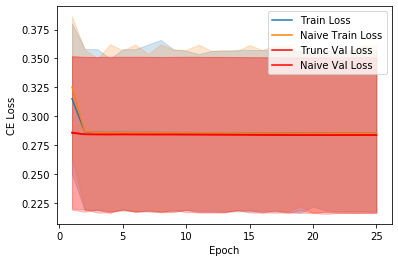

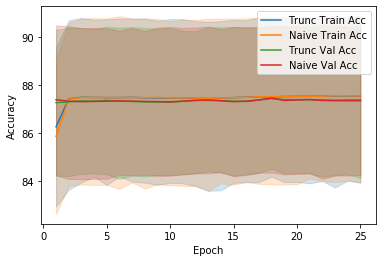

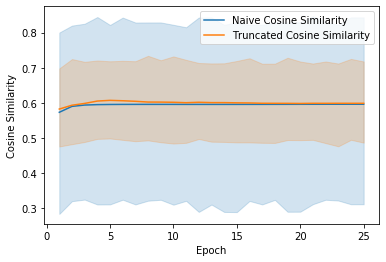

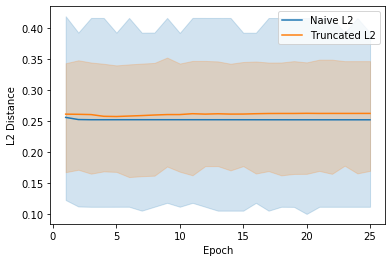

100%|██████████| 5/5 [00:00<00:00, 118.14it/s]

Standard Test Accuracy: 0    81.760002
0    91.110001
0    89.800003
0    83.919998
0    90.879997
Name: test_prec1, dtype: float64
Truncated Test Accuracy: 0    89.800003
0    91.129997
0    90.889999
0    81.779999
0    83.919998
Name: test_prec1, dtype: float64


In [9]:
# plot results
plot()